In [2]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((-1, 28, 28, 1)) #60000개
test_images = test_images.reshape((-1, 28, 28, 1))

#0~1 사이 값으로 정규화
train_images = train_images / 255.
test_images = test_images / 255.

#loss값 낮아지도록 학습 so 과적합 문제
#valid set: 전체 train의 75% 정도 가져와서 overfitting 일어나는지 확인 & test는 최종 검사용
valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.15, shuffle=True)

11501568/11490434 [==============================] - 0s 0us/step


In [18]:
# 1. Functional API 방법
# cf. sequential은 add
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout

inputs = Input(shape=(28, 28, 1))
conv1 = Conv2D(32, (3, 3), activation=tf.nn.relu)(inputs) #(필터 개수, (필터 shape))
pool1 = MaxPool2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation=tf.nn.relu)(pool1)
pool2 = MaxPool2D((2, 2))(conv2)

conv3 = Conv2D(64, (3, 3), activation=tf.nn.relu)(pool2)
flat = Flatten()(conv3) #dense layer에 넣기 위해 flatten

dense4 = Dense(64, activation='relu')(flat)
drop4 = Dropout(rate=0.2)(dense4) #dropout: 일반화 -> 20% 비율로 dense4 skip
outputs = Dense(10, activation='softmax')(drop4)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)          3692

model save 위한 modelchecking과 earlystopping

In [20]:
#맨 마지막에 나오는 모델은 과적합된 bad model! 
#so, 학습을 진행하면서 모델 save해야 함 -> 앞쪽에 나온 좋은 모델 가져오기 위해!
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/models'
model_path = f"{MODEL_SAVE_FOLDER}mnist-{{epoch:d}}--{{val_loss:.5f}}--{{val_accuracy:.5f}}.hdf5"

# 한 epoch 끝날 때마다 모델을 어디에 save할지 정하는 것
# save_weights_only: model weight만 save
# save_best_only: best인 경우에만 save
cb_checkpoint = ModelCheckpoint(filepath=model_path,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True)

# patience: no improve되는 epoch의 수("연속 n까지는 참는 것!")
cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels),
                 epochs=100, batch_size=200,
                 callbacks=[cb_checkpoint, cb_early_stopping])
#callback: system이 학습하다가 우리가 정해준 객체 호출하는 것

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.8932
Epoch 1: val_accuracy improved from -inf to 0.97518, saving model to /content/drive/MyDrive/modelsmnist-1--0.07696--0.97518.hdf5
300/300 [==============================] - 6s 18ms/step - loss: 0.3528 - accuracy: 0.8932 - val_loss: 0.0770 - val_accuracy: 0.9752
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9735
Epoch 2: val_accuracy improved from 0.97518 to 0.98553, saving model to /content/drive/MyDrive/modelsmnist-2--0.04649--0.98553.hdf5
300/300 [==============================] - 5s 18ms/step - loss: 0.0881 - accuracy: 0.9735 - val_loss: 0.0465 - val_accuracy: 0.9855
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.9813
Epoch 3: val_accuracy improved from 0.98553 to 0.98800, saving model to /content/drive/MyDrive/modelsmnist-3--0.03586--0.98800.hdf5
300/300 [==============================] - 6s 20ms/s

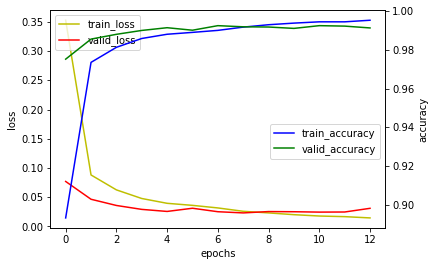

In [22]:
# early stopping 때문에 epoch 13까지만 돌림
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='valid_loss')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='valid_accuracy')
acc_ax.set_xlabel('epochs')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5))

plt.show()

In [23]:
# best model -> 해당 파일 구글 드라이브 저장
saved_path = '/content/drive/MyDrive/modelsmnist-7--0.02516--0.99247.hdf5'
loaded_model = tf.keras.models.load_model(saved_path)

print(f"Loss, Accuracy {model.evaluate(test_images, test_labels)}")

47/47 [==============================] - 0s 5ms/step - loss: 0.0238 - accuracy: 0.9940
Loss, Accuracy [0.023766281083226204, 0.9940000176429749]


In [24]:
!ls -la '/content/drive/MyDrive/models'
#model 용량 큼!

total 0


In [25]:
!cd '/content/drive/MyDrive/models'

In [26]:
!rm '/content/drive/MyDrive/models'*

rm: cannot remove '/content/drive/MyDrive/models': Is a directory


런타임 초기화 -> 파일 마운트 -> 학습시키지 않고 불러오기

In [ ]:
# savec_path: 앞서 드라이브에 저장한 best model 불러오기
saved_path = '/content/drive/MyDrive/mnist-9--0.02006--0.99376.hdf5'
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.load_weights(saved_path)

print(f"Loss, Accuracy {model.evaluate(test_images, test_labels)}")

47/47 [==============================] - 9s 4ms/step - loss: 0.0195 - accuracy: 0.9933
Loss, Accuracy [0.019534043967723846, 0.9933333396911621]


subclassing 방식
- sequential이나 functional은 변경불가
- loss함수 변경 용이

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout

class MNISTModel(Model):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.conv1 = Conv2D(32, (3,3), activation='relu')
    self.pool1 = MaxPool2D()
    self.conv2 = Conv2D(64, (3,3), activation='relu')
    self.pool2 = MaxPool2D()
    self.conv3 = Conv2D(64, (3,3), activation='relu')
    self.flat = Flatten()
    self.dense4 = Dense(64, activation='relu')
    self.drop = Dropout(0.2)
    self.outputs = Dense(10, activation='softmax')
  
  #Forward 함수
  #이미 model에 정의된 call 함수 재정의
  def call(self, inputs, training=False):
    net = self.conv1(inputs)
    net = self.pool1(net)
    net = self.conv2(net)
    net = self.pool2(net)
    net = self.conv3(net)
    net = self.flat(net)
    net = self.dense4(net)
    net = self.drop(net)
    net = self.outputs(net)

    return net

model = MNISTModel()
inputs = Input(shape=(28,28,1))
model(inputs)

model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  320       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           multiple                  36928     
                                                                 
 flatten (Flatten)           multiple                  

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/content/models'
model_path = f"{MODEL_SAVE_FOLDER}mnist-{{epoch:d}}--{{val_loss:.5f}}--{{val_accuracy:.5f}}.hdf5"

# 한 epoch 끝날 때마다 모델을 어디에 save할지 정하는 것
# save_weights_only: model weight만 save
# save_best_only: best인 경우에만 save
cb_checkpoint = ModelCheckpoint(filepath=model_path,
                                monitor='val_accuracy',
                                save_weights_only=True,
                                verbose=1,
                                save_best_only=True)

# patience: no improve되는 epoch의 수("연속 n까지는 참는 것!")
cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

In [4]:
#맨 처음에 모델 돌릴 때 hist 찍기 위함
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels),
                 epochs=100, batch_size=200,
                 callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100
294/300 [============================>.] - ETA: 0s - loss: 0.3734 - accuracy: 0.8835
Epoch 1: val_accuracy improved from -inf to 0.97729, saving model to /content/modelsmnist-1--0.07453--0.97729.hdf5
300/300 [==============================] - 12s 8ms/step - loss: 0.3684 - accuracy: 0.8851 - val_loss: 0.0745 - val_accuracy: 0.9773
Epoch 2/100
298/300 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9742
Epoch 2: val_accuracy improved from 0.97729 to 0.98553, saving model to /content/modelsmnist-2--0.04612--0.98553.hdf5
300/300 [==============================] - 2s 6ms/step - loss: 0.0862 - accuracy: 0.9743 - val_loss: 0.0461 - val_accuracy: 0.9855
Epoch 3/100
296/300 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9820
Epoch 3: val_accuracy improved from 0.98553 to 0.98859, saving model to /content/modelsmnist-3--0.03337--0.98859.hdf5
300/300 [==============================] - 2s 6ms/step - loss: 0.0612 - accuracy: 0.9821 - val_

In [45]:
# savec_path: 앞서 드라이브에 저장한 best model 불러오기
saved_path = '/content/drive/MyDrive/mnist-9--0.02006--0.99376.hdf5'
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.load_weights(saved_path)

print(f"Loss, Accuracy {model.evaluate(test_images, test_labels)}")

47/47 [==============================] - 0s 4ms/step - loss: 0.0195 - accuracy: 0.9927
Loss, Accuracy [0.019514624029397964, 0.9926666617393494]


In [36]:
output = model(test_images)
output.shape

TensorShape([1500, 10])

In [37]:
#softmax 거친 predict 값
output[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([7.95260494e-05, 7.30366010e-05, 9.98218715e-01, 1.31021929e-03,
       1.13874306e-08, 1.23768518e-06, 2.59468447e-06, 3.10109492e-04,
       4.44269790e-06, 2.09293542e-08], dtype=float32)>

In [38]:
#가장 확률 높은 예측값 출력
import numpy as np
np.argmax(output[0])

2

In [41]:
#test label과 예측값 일치 -> 잘 맞힌 것!
test_labels[0]

2